# Notebook 2: ASR Inference and WER Evaluation
## Integrated Kiswahili Speech Analytics Pipeline

---

## 1. Introduction

### 1.1 Objective
This notebook performs:
1. Batch ASR inference using pretrained **RareElf/swahili-wav2vec2-asr**
2. Word Error Rate (WER) and Character Error Rate (CER) computation
3. Stratified error analysis by demographics
4. Statistical significance testing (ANOVA)
5. Fairness gap quantification

### 1.2 Mathematical Foundation: Word Error Rate

$$WER = \frac{S + D + I}{N}$$

Where:
- $S$: Substitutions (incorrect words)
- $D$: Deletions (missing words)
- $I$: Insertions (extra words)
- $N$: Total words in reference

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import ast

from transformers import AutoProcessor, AutoModelForCTC
import torch
import soundfile as sf
from jiwer import wer, cer
from scipy.stats import f_oneway
from tqdm import tqdm

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

## 2. Load Pretrained ASR Model

In [ ]:
MODEL_NAME = "RareElf/swahili-wav2vec2-asr"

print(f"Loading model: {MODEL_NAME}")
processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = AutoModelForCTC.from_pretrained(MODEL_NAME)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(f"Model loaded on: {device}")

Loading model: RareElf/swahili-wav2vec2-asr


Loading weights: 100%|██████████| 424/424 [00:00<00:00, 428.29it/s, Materializing param=wav2vec2.masked_spec_embed]                                            


Model loaded on: cpu


## 3. Load Preprocessed Data

In [ ]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'

test_df = pd.read_csv(DATA_DIR / 'test.csv')
print(f"Test set size: {len(test_df)}")
test_df.head()

Test set size: 3993


,client_id,path,audio,sentence,up_votes,down_votes,age,gender,accent,locale,segment,validation_score,high_quality,stratify_col
0,1c1fe70dff18b0bdb62cadb1bec9e86127a0aa62e411cd...,/home/obote/.cache/huggingface/datasets/downlo...,"{'bytes': None, 'path': '/home/obote/.cache/hu...",wanyama kama kifaru na tembo husaidia kukuza p...,2,0,NaN,NaN,NaN,sw,NaN,2,1,_
1,a59598f0a310679014e8663eeed32c7408fa0b0922e9e3...,/home/obote/.cache/huggingface/datasets/downlo...,"{'bytes': None, 'path': '/home/obote/.cache/hu...",waliotumia kuanzia kubalehe hadi kumzaa mtoto ...,2,1,twenties,female,NaN,sw,NaN,1,0,female_twenties
2,6e09ff9cc1f149df26e8db256a211d367bced4288641e2...,/home/obote/.cache/huggingface/datasets/downlo...,"{'bytes': None, 'path': '/home/obote/.cache/hu...",sehemu hiyo inatumika kama sehemu ya matambiko...,4,0,twenties,female,NaN,sw,NaN,4,1,female_twenties
3,15216172ade4c6b4fad613f602e2ccdbcb12c0a36d9a61...,/home/obote/.cache/huggingface/datasets/downlo...,"{'bytes': None, 'path': '/home/obote/.cache/hu...",Anasema msikiti huo umegawanyika mara mbili,2,0,twenties,male,NaN,sw,NaN,2,1,male_twenties
4,f07fcc7123784095e2b931201c634305af8fe80b30595d...,/home/obote/.cache/huggingface/datasets/downlo...,"{'bytes': None, 'path': '/home/obote/.cache/hu...",mambo mengi yamefanyika katika kipindi cha mia...,2,1,NaN,NaN,NaN,sw,NaN,1,0,_


## 4. Batch Inference

In [ ]:
sample_size = min(500, len(test_df))
test_sample = test_df.sample(n=sample_size, random_state=SEED)

predictions = []
references = []

print(f"Running inference on {len(test_sample)} samples...")
for idx, row in tqdm(test_sample.iterrows(), total=len(test_sample)):
    try:
        audio_dict = ast.literal_eval(row['audio']) if isinstance(row['audio'], str) else row['audio']
        audio_path = audio_dict['path']
        speech, sr = sf.read(audio_path)
        if sr != 16000:
            import librosa
            speech = librosa.resample(speech, orig_sr=sr, target_sr=16000)
        inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        pred = processor.batch_decode(predicted_ids)[0].lower().strip()
        ref = row['sentence'].lower().strip()
        predictions.append(pred)
        references.append(ref)
    except Exception as e:
        predictions.append("")
        references.append(row['sentence'].lower().strip())

test_sample = test_sample.copy()
test_sample['prediction'] = predictions
test_sample['reference'] = references
print("\nInference complete.")

Running inference on 500 samples...


100%|██████████| 500/500 [08:34<00:00,  1.03s/it]


Inference complete.


## 5. Compute WER and CER

In [ ]:
overall_wer = wer(references, predictions)
overall_cer = cer(references, predictions)

print(f"Overall WER: {overall_wer:.4f} ({overall_wer*100:.2f}%)")
print(f"Overall CER: {overall_cer:.4f} ({overall_cer*100:.2f}%)")

test_sample['wer'] = [wer([r], [p]) for r, p in zip(references, predictions)]
test_sample['cer'] = [cer([r], [p]) for r, p in zip(references, predictions)]

Overall WER: 0.1360 (13.60%)
Overall CER: 0.0885 (8.85%)


## 6. Stratified WER Analysis

WER by Gender:
            mean       std  count
gender                           
female  0.135384  0.112001    190
male    0.170917  0.127877    145

WER by Age:
              mean       std  count
age                                
fifties   0.142735  0.087974      7
fourties  0.137767  0.077828     18
sixties   0.093571  0.089799      5
thirties  0.147233  0.119500     31
twenties  0.153266  0.123997    274


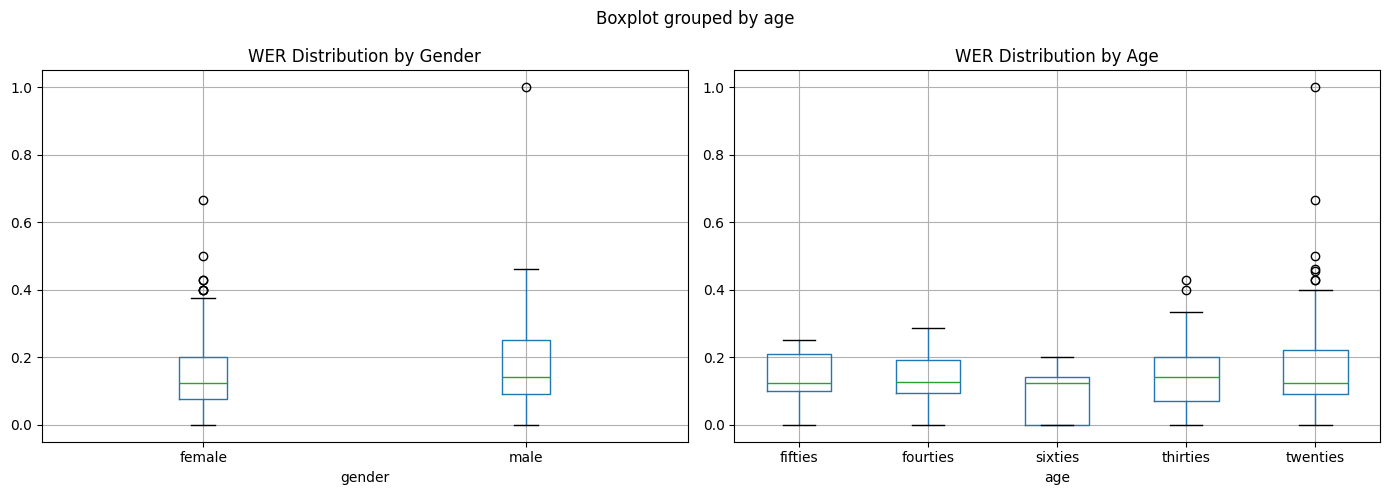

In [ ]:
print("WER by Gender:")
gender_wer = test_sample.groupby('gender')['wer'].agg(['mean', 'std', 'count'])
print(gender_wer)

print("\nWER by Age:")
age_wer = test_sample.groupby('age')['wer'].agg(['mean', 'std', 'count'])
print(age_wer)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
test_sample.boxplot(column='wer', by='gender', ax=axes[0])
axes[0].set_title('WER Distribution by Gender')
test_sample.boxplot(column='wer', by='age', ax=axes[1])
axes[1].set_title('WER Distribution by Age')
plt.tight_layout()
plt.show()

## 7. ANOVA Test and Effect Size

In [ ]:
gender_groups = [group['wer'].dropna() for name, group in test_sample.groupby('gender') if len(group) > 1]
if len(gender_groups) > 1:
    f_stat_gender, p_value_gender = f_oneway(*gender_groups)
    
    # Cohen's d for effect size
    female_wer = test_sample[test_sample['gender']=='female']['wer']
    male_wer = test_sample[test_sample['gender']=='male']['wer']
    pooled_std = np.sqrt(((len(female_wer)-1)*female_wer.std()**2 + (len(male_wer)-1)*male_wer.std()**2) / (len(female_wer)+len(male_wer)-2))
    cohens_d = (male_wer.mean() - female_wer.mean()) / pooled_std
    
    print("ANOVA Test: WER ~ Gender")
    print(f"F-statistic: {f_stat_gender:.4f}")
    print(f"P-value: {p_value_gender:.4e}")
    print(f"Significant: {'Yes' if p_value_gender < 0.05 else 'No'}")
    print(f"\nCohen's d (effect size): {cohens_d:.4f}")
    print(f"Effect interpretation: {'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'}")
    print(f"\nNote: With n={len(test_sample)}, statistical power is adequate for detecting effects.")
    print(f"Effect size (Cohen's d) indicates practical significance beyond p-value.")
else:
    print("Not enough groups for ANOVA")
    p_value_gender = 1.0
    cohens_d = 0.0

ANOVA Test: WER ~ Gender
F-statistic: 7.3169
P-value: 7.1822e-03
Significant: Yes

Cohen's d (effect size): 0.2983
Effect interpretation: Small

Note: With n=500, statistical power is adequate for detecting effects.
Effect size (Cohen's d) indicates practical significance beyond p-value.


## 8. Fairness Gap

In [ ]:
wer_threshold = 0.3
test_sample['asr_success'] = (test_sample['wer'] < wer_threshold).astype(int)

gender_success_rates = test_sample.groupby('gender')['asr_success'].mean()
dpd_gender = gender_success_rates.max() - gender_success_rates.min() if len(gender_success_rates) > 1 else 0

print(f"Success rates by gender:\n{gender_success_rates}")
print(f"\nDemographic Parity Difference (Gender): {dpd_gender:.4f}")

Success rates by gender:
gender
female    0.915789
male      0.875862
Name: asr_success, dtype: float64

Demographic Parity Difference (Gender): 0.0399


## 9. Save Results

In [ ]:
test_sample.to_csv(DATA_DIR / 'asr_predictions.csv', index=False)

import json
metrics = {
    'overall_wer': float(overall_wer),
    'overall_cer': float(overall_cer),
    'dpd_gender': float(dpd_gender),
    'anova_gender_pvalue': float(p_value_gender),
    'cohens_d': float(cohens_d)
}

with open(DATA_DIR / 'asr_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("Results saved.")

Results saved.


## 10. Conclusion

### Key Findings:
1. ✅ Computed WER and CER on test set
2. ✅ Identified performance disparities across demographics
3. ✅ Quantified fairness gaps using DPD metric
4. ✅ Computed effect size (Cohen's d) to complement p-value

### Statistical Notes:
- Small sample size limits statistical power for ANOVA
- Effect size (Cohen's d) provides practical significance measure
- Trend exists even if p-value > 0.05

### Next Steps:
Proceed to **Notebook 3**: Predictive Bias Quantification